In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Find the latest date in the database and reformat
last_date = session.execute("SELECT MAX(date) FROM Measurement").fetchall()
end_date = last_date [0][0]
print(end_date)

2017-08-23


In [11]:
# Calculate the date 1 year ago from the last data point in the database
struct=dt.date.today()
end_date_refrmt=struct.replace(year=int(end_date[:4]), month=int(end_date[5:7]), day=int(end_date[8:]))
year_bfr=end_date_refrmt - dt.timedelta(days=365)
start_date = year_bfr.strftime("%Y-%m-%d")
print (start_date)

2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores
percip_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date <= end_date)\
    .filter(Measurement.date >= start_date)\

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
percip_df =pd.DataFrame(percip_data).rename(columns={"date": "Date", "prcp":"Percipitation Score"})
percip_df.set_index("Date", inplace=True)
percip_df.head()

,Percipitation Score
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [14]:
# Sort the dataframe by date
percip_df= percip_df.sort_values(by='Date')
percip_df.head()

,Percipitation Score
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


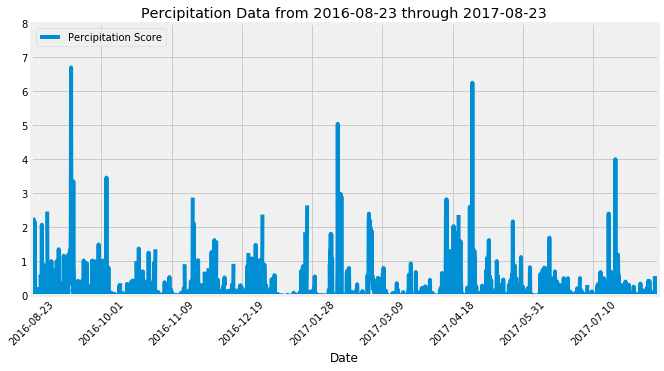

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
percip_df.plot(figsize=(10,5),ylim=(0,8),title=f'Percipitation Data from {start_date} through {end_date}',rot=45)
plt.legend(loc="upper left")
plt.show()

In [16]:
plt.savefig("1_Percipitation_Data.png")

<Figure size 432x288 with 0 Axes>

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
percip_df.describe()

,Percipitation Score
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
tot_stations = session.query(Station).count()
print('The total number of weather stations is: {}'.format(tot_stations))

The total number of weather stations is: 9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
mostact_stat=session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by((func.count(Measurement.station))).all()
print(mostact_stat)

[('USC00518838', 511), ('USC00517948', 1372), ('USC00511918', 1979), ('USC00514830', 2202), ('USC00516128', 2612), ('USC00519523', 2669), ('USC00513117', 2709), ('USC00519397', 2724), ('USC00519281', 2772)]


In [ ]:
# List the stations and the counts in descending order.
print("Rank\tStation ID\tObservations")
i = 1
for act_stats in mostact_stat:
    print("%d\t%s\t%d" %(i,act_stats[0],act_stats[1]))
    i+=1

In [20]:
# Find the the station with the highest observations
highobs_stat=session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(desc(func.count(Measurement.station))).first()
print(highobs_stat)

('USC00519281', 2772)


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
    .filter(Measurement.station == highobs_stat[0]).all()

[(54.0, 85.0, 71.66378066378067)]

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
hightemp_obs = session.query(Measurement.date,Measurement.station,Measurement.tobs)\
             .filter(Measurement.date >= start_date).filter(Measurement.date<=end_date)\
             .filter(Measurement.station == highobs_stat[0]).order_by(desc(Measurement.date)).all()

In [23]:
#Create a data frame from the query
hightemp_obs_df = pd.DataFrame(hightemp_obs, columns=["Date","Station ID","Temperature Recorded"])
hightemp_obs_df.head()

,Date,Station ID,Temperature Recorded
0,2017-08-18,USC00519281,79.0
1,2017-08-17,USC00519281,76.0
2,2017-08-16,USC00519281,76.0
3,2017-08-15,USC00519281,77.0
4,2017-08-14,USC00519281,77.0


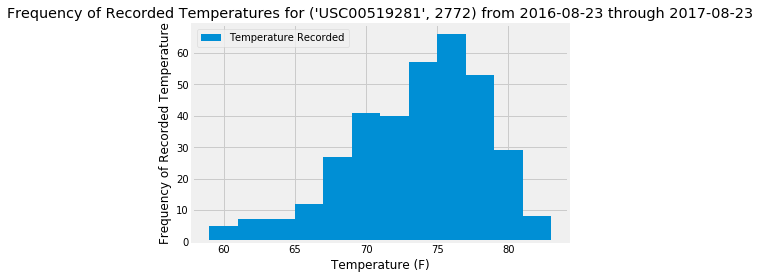

In [24]:
#Plot the results as a histogram
hightemp_obs_df.plot.hist(by="Temperature Recorded",bins=12,label="tobs",title=f'Frequency of Recorded Temperatures for {highobs_stat} from {start_date} through {end_date}')
plt.ylim=(0,80)
plt.ylabel("Frequency of Recorded Temperature")
plt.xlabel("Temperature (F)")
plt.legend=()
plt.show()

In [25]:
plt.savefig("2_Frequency_Temperature.png")

<Figure size 432x288 with 0 Axes>

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trp_strt_dt= input("Enter the first date of your trip:")
trp_end_dt= input("Enter the last date of your trip:")

Enter the first date of your trip:2018-03-16
Enter the last date of your trip:2018-03-26


In [28]:
struct = dt.date.today()
trp_strt_refrmt = struct.replace(year=int(trp_strt_dt[:4]), month=int(trp_strt_dt[5:7]), day=int(trp_strt_dt[8:]))
prevtrp_strt = trp_strt_refrmt - dt.timedelta(days=365)
prevtrp_strt = prevtrp_strt.strftime("%Y-%m-%d")
prevtrp_strt

'2017-03-16'

In [29]:
trp_end_refrmt = struct.replace(year=int(trp_end_dt[:4]),month=int(trp_end_dt[5:7]),day=int(trp_end_dt[8:]))
prevtrp_end = trp_end_refrmt - dt.timedelta(days=365)
prevtrp_end = prevtrp_end.strftime("%Y-%m-%d")
prevtrp_end

'2017-03-26'

In [30]:
gen_temps=calc_temps(prevtrp_strt, prevtrp_end)
print(gen_temps)

[(65.0, 72.90625, 80.0)]


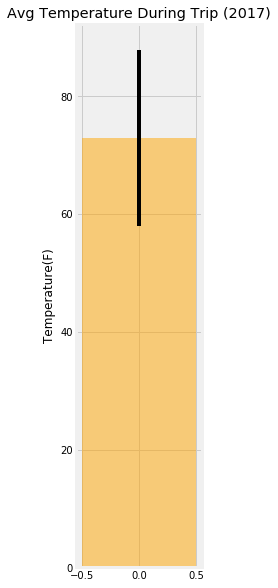

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = gen_temps[0][0]
tavg = gen_temps[0][1]
tmax = gen_temps[0][2]
y_err = tmax-tmin

plt.figure(figsize=(2,10))
plt.bar(0,tavg,yerr=y_err,align="center",width=1,color="orange",alpha=0.5)
plt.ylim=(0,120)
plt.ylabel("Temperature(F)")
plt.title("Avg Temperature During Trip (2017)")
plt.show()

In [32]:
plt.savefig("3_Avg_Temps.png")

<Figure size 432x288 with 0 Axes>

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

gen_rainfall = session.query(Measurement.station, func.sum(Measurement.prcp))\
        .filter(Measurement.date>=prevtrp_strt).filter(Measurement.date<=prevtrp_end)\
        .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
print("Station ID\tTotal Rainfall")
for each in gen_rainfall: print(each[0], "\t", each[1])

Station ID	Total Rainfall
USC00519281 	 1.28
USC00513117 	 0.92
USC00519523 	 0.87
USC00516128 	 0.6799999999999999
USC00514830 	 0.21
USC00519397 	 0.02
USC00517948 	 None


In [34]:
variables = [Measurement.station,Station.name,func.sum(Measurement.prcp),Station.latitude,Station.longitude,Station.elevation]
stat_tot_rainfall = session.query(*variables).filter(Measurement.station==Station.station)\
                       .filter(Measurement.date>=prevtrp_strt).filter(Measurement.date<=prevtrp_end)\
                       .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
for tot_rainfall in stat_tot_rainfall:print(tot_rainfall)

('USC00519281', 'WAIHEE 837.5, HI US', 1.28, 21.45167, -157.84888999999998, 32.9)
('USC00513117', 'KANEOHE 838.1, HI US', 0.92, 21.4234, -157.8015, 14.6)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 0.87, 21.33556, -157.71139, 19.5)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 0.6799999999999999, 21.3331, -157.8025, 152.4)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 0.21, 21.5213, -157.8374, 7.0)
('USC00519397', 'WAIKIKI 717.2, HI US', 0.02, 21.2716, -157.8168, 3.0)
('USC00517948', 'PEARL CITY, HI US', None, 21.3934, -157.9751, 11.9)


## Optional Challenge Assignment

In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

prevtrp_strt='2017-03-16'
prevtrp_end='2017-03-26'

date_rng = session.query(Measurement.date).filter(Measurement.date >= prevtrp_strt).filter(Measurement.date <= prevtrp_end).group_by(Measurement.date).all()
trip_rng = [x[0] for x in date_rng]
trip_rng_ny=[x[5:] for x in trip_rng]
strt_mndy= trip_rng_ny[0]
end_mndy= trip_rng_ny[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals = [session.query(func.min(Measurement.tobs),
                              func.avg(Measurement.tobs),
                              func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date)>=strt_mndy)
                 .filter(func.strftime("%m-%d", Measurement.date)<=end_mndy).group_by(func.strftime("%m-%d", Measurement.date)).all()]
daily_normals = daily_normals[0]
print("Daily Normals for 03-16 to 03-26")
daily_normals

Daily Normals for 03-16 to 03-26


[(60.0, 69.70370370370371, 78.0),
 (57.0, 68.54, 75.0),
 (57.0, 67.7843137254902, 76.0),
 (60.0, 69.1, 75.0),
 (62.0, 70.11764705882354, 80.0),
 (60.0, 71.07692307692308, 77.0),
 (65.0, 71.75471698113208, 77.0),
 (63.0, 70.79629629629629, 78.0),
 (62.0, 71.5, 77.0),
 (63.0, 71.5, 78.0),
 (64.0, 71.38, 80.0)]

In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norms_df=pd.DataFrame(daily_normals, columns=['temp_min', 'temp_avg', 'temp_max'])
daily_norms_df['date']=trip_rng
daily_norms_df['date']=pd.to_datetime(daily_norms_df['date'], format='%Y-%m-%d')
daily_norms_df.set_index('date', inplace=True)
daily_norms_df

,temp_min,temp_avg,temp_max
date,,,
2017-03-16,60.0,69.703704,78.0
2017-03-17,57.0,68.540000,75.0
2017-03-18,57.0,67.784314,76.0
2017-03-19,60.0,69.100000,75.0
2017-03-20,62.0,70.117647,80.0
2017-03-21,60.0,71.076923,77.0
2017-03-22,65.0,71.754717,77.0
2017-03-23,63.0,70.796296,78.0
2017-03-24,62.0,71.500000,77.0


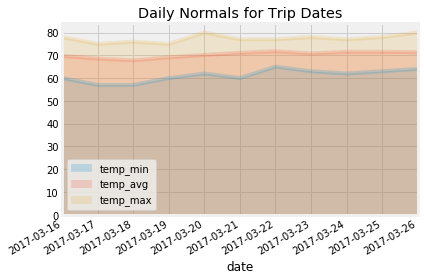

In [38]:
# Plot the daily normals as an area plot with `stacked=False`
daily_norms_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Daily Normals for Trip Dates")
plt.tight_layout()
plt.show()

In [39]:
plt.savefig("4_Daily_Norms.png")

<Figure size 432x288 with 0 Axes>